## Machine preparation

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [2]:
# from qiskit import IBMQ
# provider = IBMQ.enable_account('PUT_IBMQ_TOKEN_HERE')

# import pennylane as qml
# dev = qml.device('qiskit.ibmq', wires=2, backend='ibmq_lima', provider=provider)


dev = qml.device("default.qubit", wires=2)

In [3]:
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2)
        / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

In [4]:
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

In [5]:
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [6]:
def variational_classifier(var, x):
    weights = var[0]
    bias = var[1]
    return circuit(weights, x) + bias

In [7]:
@qml.qnode(dev)
def circuit(weights, angles):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def variational_classifier(var, angles):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles) + bias


def cost(weights, features, labels):
    print("calling cost with", len(features))
    predictions = [variational_classifier(weights, f) for f in features]
    return square_loss(labels, predictions)

## Load classic data

In [8]:
import pandas as pd

df = pd.read_csv('iris.data')

print(df.describe())

       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


In [9]:
print(df.to_string())

     sepal_length  sepal_width  petal_length  petal_width            class
0             5.1          3.5           1.4          0.2      Iris-setosa
1             4.9          3.0           1.4          0.2      Iris-setosa
2             4.7          3.2           1.3          0.2      Iris-setosa
3             4.6          3.1           1.5          0.2      Iris-setosa
4             5.0          3.6           1.4          0.2      Iris-setosa
5             5.4          3.9           1.7          0.4      Iris-setosa
6             4.6          3.4           1.4          0.3      Iris-setosa
7             5.0          3.4           1.5          0.2      Iris-setosa
8             4.4          2.9           1.4          0.2      Iris-setosa
9             4.9          3.1           1.5          0.1      Iris-setosa
10            5.4          3.7           1.5          0.2      Iris-setosa
11            4.8          3.4           1.6          0.2      Iris-setosa
12            4.8        

In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df["class"])
df["class"]=le.transform(df["class"])
le.fit(df["class"])
df["class"]=le.transform(df["class"])
# df = df[df["class"] != 2]
# df['class'] = df['class'].replace([0],-1)
print(df)

     sepal_length  sepal_width  petal_length  petal_width  class
0             5.1          3.5           1.4          0.2      0
1             4.9          3.0           1.4          0.2      0
2             4.7          3.2           1.3          0.2      0
3             4.6          3.1           1.5          0.2      0
4             5.0          3.6           1.4          0.2      0
..            ...          ...           ...          ...    ...
145           6.7          3.0           5.2          2.3      2
146           6.3          2.5           5.0          1.9      2
147           6.5          3.0           5.2          2.0      2
148           6.2          3.4           5.4          2.3      2
149           5.9          3.0           5.1          1.8      2

[150 rows x 5 columns]


In [11]:
min_max_scaler = preprocessing.MinMaxScaler()
df[["sepal_length", "sepal_width", "petal_length", "petal_width"]] = min_max_scaler.fit_transform(df[["sepal_length", "sepal_width", "petal_length", "petal_width"]])

In [12]:
df

,sepal_length,sepal_width,petal_length,petal_width,class
0,0.222222,0.625000,0.067797,0.041667,0
1,0.166667,0.416667,0.067797,0.041667,0
2,0.111111,0.500000,0.050847,0.041667,0
3,0.083333,0.458333,0.084746,0.041667,0
4,0.194444,0.666667,0.067797,0.041667,0
...,...,...,...,...,...
145,0.666667,0.416667,0.711864,0.916667,2
146,0.555556,0.208333,0.677966,0.750000,2
147,0.611111,0.416667,0.711864,0.791667,2
148,0.527778,0.583333,0.745763,0.916667,2


In [13]:
X = df.to_numpy()[:, 0:4]
print("First X sample (original)  :", X[0])
X_pad = X

# pad the vectors to size 2^2 with constant values
# padding = 0.3 * np.ones((len(X), 1))
# X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
# print("First X sample (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("First X sample (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm])
print("First features sample      :", features[0])

Y = df.to_numpy()[:, -1]

First X sample (original)  : [0.22222222 0.625      0.06779661 0.04166667]
First X sample (normalized): [0.33262469 0.93550694 0.10147872 0.06236713]
First features sample      : [ 0.23879026 -0.55107359  0.55107359 -1.22918084  1.22918084]


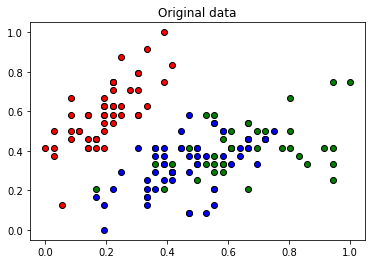

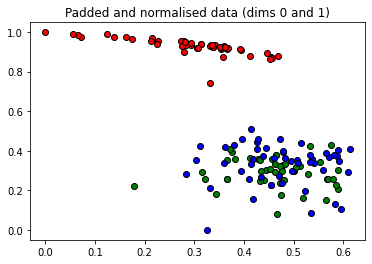

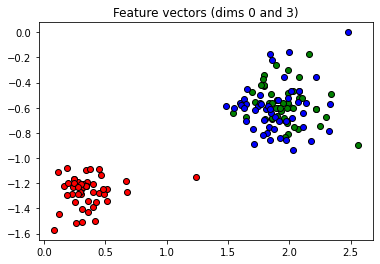

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 2], X[:, 1][Y == 2], c="g", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == 0], X[:, 1][Y == 0], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(
    X_norm[:, dim1][Y == 2], X_norm[:, dim2][Y == 2], c="g", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == 0], X_norm[:, dim2][Y == 0], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(
    features[:, dim1][Y == 2], features[:, dim2][Y == 2], c="g", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == 0], features[:, dim2][Y == 0], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

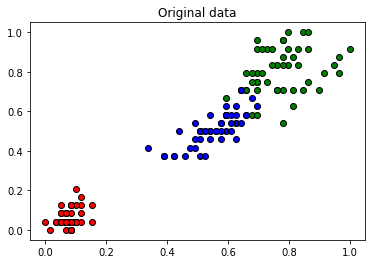

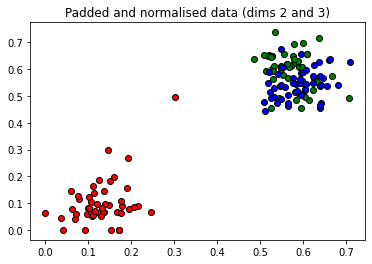

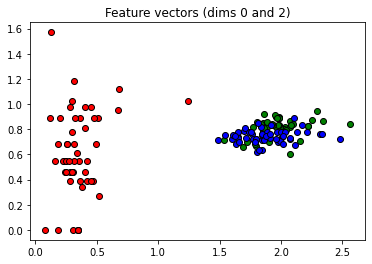

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 2][Y == 2], X[:, 3][Y == 2], c="g", marker="o", edgecolors="k")
plt.scatter(X[:, 2][Y == 1], X[:, 3][Y == 1], c="b", marker="o", edgecolors="k")
plt.scatter(X[:, 2][Y == 0], X[:, 3][Y == 0], c="r", marker="o", edgecolors="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 2
dim2 = 3
plt.scatter(
    X_norm[:, dim1][Y == 2], X_norm[:, dim2][Y == 2], c="g", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    X_norm[:, dim1][Y == 0], X_norm[:, dim2][Y == 0], c="r", marker="o", edgecolors="k"
)
plt.title("Padded and normalised data (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 2
plt.scatter(
    features[:, dim1][Y == 2], features[:, dim2][Y == 2], c="g", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", edgecolors="k"
)
plt.scatter(
    features[:, dim1][Y == 0], features[:, dim2][Y == 0], c="r", marker="o", edgecolors="k"
)
plt.title("Feature vectors (dims {} and {})".format(dim1, dim2))
plt.show()

In [24]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]


## Optimization

In [28]:
num_qubits = 2
num_layers = 6
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 1.0)

In [30]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
var = var_init
for it in range(60):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.rint(variational_classifier(var, f)) for f in feats_train]
    predictions_val = [np.rint(variational_classifier(var, f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(var, features, Y), acc_train, acc_val)
    )

calling cost with 5
calling cost with 150
Iter:     1 | Cost: 1.8897150 | Acc train: 0.2857143 | Acc validation: 0.3421053 
calling cost with 5
calling cost with 150
Iter:     2 | Cost: 1.8355127 | Acc train: 0.3035714 | Acc validation: 0.3421053 
calling cost with 5
calling cost with 150
Iter:     3 | Cost: 1.7742946 | Acc train: 0.3035714 | Acc validation: 0.3421053 
calling cost with 5
calling cost with 150
Iter:     4 | Cost: 1.6717232 | Acc train: 0.3125000 | Acc validation: 0.3684211 
calling cost with 5
calling cost with 150
Iter:     5 | Cost: 1.5474391 | Acc train: 0.3125000 | Acc validation: 0.3947368 
calling cost with 5
calling cost with 150
Iter:     6 | Cost: 1.3887803 | Acc train: 0.2500000 | Acc validation: 0.3421053 
calling cost with 5
calling cost with 150
Iter:     7 | Cost: 1.2601195 | Acc train: 0.2321429 | Acc validation: 0.2894737 
calling cost with 5
calling cost with 150
Iter:     8 | Cost: 1.1322451 | Acc train: 0.2500000 | Acc validation: 0.2631579 
calling 